In [1]:
import pandas as pd
import re 
import numpy as np

### C4.5算法
c4.5算法是一种决策树算法 决策树算法作为分类算法,目标就是将具有P维的特征的n个样本分到C类中去,常见的决策树算法有ID3.C4.5 CART

In [13]:
# date = [
#     ['晴天','寒冷','正常','弱','进行'],
#     ['晴天','适中','正常','强','进行'],
#     ['晴天','炎热','高','弱','取消'],
#     ['晴天','炎热','高','弱','取消'],
#     ['晴天','适中','适中','弱','取消'],
#     ['阴天','炎热','高','弱','进行'],
#     ['阴天','寒冷','正常','强','进行'],
#     ['雨天','寒冷','高','强','进行'],
#     ['雨天','适中','高','强','进行'],
# ]
date = [
    ['A','A','A','A','进行(A)'],
    ['A','B','A','B','进行(A)'],
    ['A','B','A','A','进行(A)'],
    ['B','A','A','B','取消(B)'],
    ['B','B','A','A','进行(A)'],
    ['A','A','B','A','进行(A)'],
    ['B','B','B','B','进行(A)'],
    ['A','A','B','B','取消(B)'],
    ['B','A','B','B','取消(B)'],
]
DATE_FROM = pd.DataFrame(date,columns=['样本类别1','样本类别2','样本类别3','样本类别4','分类状态'])
DATE_FROM

,样本类别1,样本类别2,样本类别3,样本类别4,分类状态
0,A,A,A,A,进行(A)
1,A,B,A,B,进行(A)
2,A,B,A,A,进行(A)
3,B,A,A,B,取消(B)
4,B,B,A,A,进行(A)
5,A,A,B,A,进行(A)
6,B,B,B,B,进行(A)
7,A,A,B,B,取消(B)
8,B,A,B,B,取消(B)


### 0.1:计算最终分类信息熵(熵)
###### 分类信息熵 = -分类状态(A)(个数)/分类总数 * log2 (分类状态(A)个数/分类总数) - 分类状态(B)(个数)/分类总数 * log2 (分类状态(B)(个数)/分类总数) 

info(D) = -6/9 * log2 (6/9) - 3/9 * log2 (3/9)

### 0.2:特征属性信息熵(条件熵)
###### 每条属性的信息相当于一种条件熵,他表示的是某种属性的条件下,各种类别出现的不确定性之和,属性的信息熵越大,表示这个属性中拥有的样本类别越不纯
属性信息熵(A) = 样本类别(A)(个数)/样本总数 * [-分类状态(A)个数 /样本类别(A)(个数) * log2 (分类状态(A)(个数)/样本类别)(A)(个数)]+[-分类状态(B)个数 /样本类别(B)(个数) * log2 (分类状态(B)(个数)/样本类别)(B)(个数)]

### 0.3 计算信息增益
###### 信息增益 = 熵 - 条件熵 熵:表示为分类信息熵,类别信息熵-属性信息熵,表示信息不确定性减少程度,如果一个属性的信息增益大,表示这个属性的样本划分可以更好的减少划分后样本的不确定性,
###### 简单来说信息增益越小,分类目标越准确
信息增益(单个特征) = 熵(分类信息熵) - 条件熵(样本类别A)

### 0.5 计算属性分裂信息度量
###### 用分裂信息度量来考虑某种属性进行分裂时分支的数量和尺寸信息,标为属性的(内在信息).
###### 信息增益率 = 信息增益/内在信息 
###### 结果会导致属性的的重要性会随着内在的信息增益的增大而减小(如果这个属性本身不确定性就很大，那我就越不倾向于选取它）,这样算是对单纯用信息增益有所补偿)
###### H(样本类别1) = -样本类别(A)(个数) / 样本类别(总数) * log2(样本类别(A)(个数) / 样本类别(总数)) - -样本类别(A)(个数) / 样本类别(总数) * log2(样本类别(A)(个数) / 样本类别(总数)) = H(样本类别1)分裂信息度量值  //样本类别1分为AB 取两个值

### 0.6 信息增益率
信息增益率(样本类别1) = 信息增益(样本类别1) / H(样本类别)内在信息

### 优缺点:
    优点:产生的分类规则易于理解,准确率较高
    缺点:在构造树的过程中,需要对数据集进行多次的顺序扫描和排序,导致算法效率低

In [ ]:
# while (当前节点”不纯“)  
# 	(1)计算当前节点的类别信息熵Info(D) （以类别取值计算）  
# 	(2)计算当前节点各个属性的信息熵Info(Ai) （以属性取值下的类别取值计算）  
# 	(3)计算各个属性的信息增益Gain(Ai)=Info(D)-Info(Ai)  
# 	(4)计算各个属性的分类信息度量H(Ai) （以属性取值计算）  
# 	(5)计算各个属性的信息增益率IGR(Ai)=Gain(Ai)/H(Ai)  
# end while  

### ID3算法原理代码详解

In [18]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from collections import Counter
import math
from math import log
import pprint

def create_data():
    datasets = [
               ['青年', '否', '否', '一般', '否'],
               ['青年', '否', '否', '好', '否'],
               ['青年', '是', '否', '好', '是'],
               ['青年', '是', '是', '一般', '是'],
               ['青年', '否', '否', '一般', '否'],
               ['中年', '否', '否', '一般', '否'],
               ['中年', '否', '否', '好', '否'],
               ['中年', '是', '是', '好', '是'],
               ['中年', '否', '是', '非常好', '是'],
               ['中年', '否', '是', '非常好', '是'],
               ['老年', '否', '是', '非常好', '是'],
               ['老年', '否', '是', '好', '是'],
               ['老年', '是', '否', '好', '是'],
               ['老年', '是', '否', '非常好', '是'],
               ['老年', '否', '否', '一般', '否'],
               ]
    labels = [u'年龄', u'有工作', u'有自己的房子', u'信贷情况', u'类别']
    # 返回数据集和每个维度的名称
    return datasets, labels
datasets, labels = create_data()
train_data = pd.DataFrame(datasets, columns=labels)

# 熵
def calc_ent(datasets):
    data_length = len(datasets)
    label_count = {}
    for i in range(data_length):
        label = datasets[i][-1]
        if label not in label_count:
            label_count[label] = 0
        label_count[label] += 1
    ent = -sum([(p/data_length)*log(p/data_length, 2) for p in label_count.values()])
    return ent

# 经验条件熵
def cond_ent(datasets, axis=0):
    data_length = len(datasets)
    feature_sets = {}
    for i in range(data_length):
        feature = datasets[i][axis]
        if feature not in feature_sets:
            feature_sets[feature] = []
        feature_sets[feature].append(datasets[i])
    cond_ent = sum([(len(p)/data_length)*calc_ent(p) for p in feature_sets.values()])
    return cond_ent

# 信息增益
def info_gain(ent, cond_ent):
    return ent - cond_ent

def info_gain_train(datasets):
    count = len(datasets[0]) - 1
    ent = calc_ent(datasets)
    best_feature = []
    for c in range(count):
        c_info_gain = info_gain(ent, cond_ent(datasets, axis=c))
        best_feature.append((c, c_info_gain))
        print('特征({}) - info_gain - {:.3f}'.format(labels[c], c_info_gain))
    # 比较大小
    best_ = max(best_feature, key=lambda x: x[-1])
    return '特征({})的信息增益最大，选择为根节点特征'.format(labels[best_[0]])

info_gain_train(np.array(datasets))

特征(年龄) - info_gain - 0.083
特征(有工作) - info_gain - 0.324
特征(有自己的房子) - info_gain - 0.420
特征(信贷情况) - info_gain - 0.363


'特征(有自己的房子)的信息增益最大，选择为根节点特征'

In [ ]:
#同样首先，我们调用模块
#matplotlib是python专门用于画图的库
import matplotlib.pyplot as plt
from sklearn import datasets
#调用线性回归函数
from sklearn.linear_model import LinearRegression
import pandas as pd

In [ ]:
def func_market2(market_data3, months, drivingForm, vehicleType):
    X = np.array(market_data3['月数'])
    Y = np.array(market_data3['价格（万元）'])
    x_ = X.reshape(X.shape[0], 1)
    quadratic_featurizer = PolynomialFeatures(degree=2)  # 实例化一个二次多项式特征实例
    X_train_quadratic = quadratic_featurizer.fit_transform(x_)  # 用二次多项式对样本x_值做变换
    regressor_quadratic = LinearRegression()  # 创建一个线性回归实例
    regressor_quadratic.fit(X_train_quadratic, Y)  # 以多项式变换后的x_值为输入，代入线性回归模型做训练
    # 市场数据少于6条，则没有市场价格
    if market_data3.shape[0] >= 10:
        X_ = np.array(months)
        xx_quadratic = quadratic_featurizer.transform(X_)
        pre_price = regressor_quadratic.predict(xx_quadratic)
        pre_price = pre_price[0]
        if (vehicleType == '牵引车') & ((drivingForm == '6×2') | (drivingForm == '4×2')):
            PM1 = round(pre_price * 0.94 * 0.66, 2)
            PM2 = round(pre_price * 1.02 * 0.66, 2)
        else:
            PM1 = round(pre_price * 0.94, 2)
            PM2 = round(pre_price * 1.02, 2)
    else:
        PM1 = 0
        PM2 = 0
    return [PM1, PM2, regressor_quadratic.coef_[2], regressor_quadratic.coef_[1], regressor_quadratic.intercept_,
            market_data3.shape[0]]

In [21]:
#导入数据集
#这里将全部数据用于训练，并没有对数据进行划分，上例中
#将数据划分为训练和测试数据，后面会讲到交叉验证
loaded_data = datasets.load_boston()
data_X = loaded_data.data
data_y = loaded_data.target

#设置线性回归模块
model = LinearRegression()
#训练数据，得出参数
model.fit(data_X, data_y)

#利用模型，对新数据，进行预测，与原标签进行比较
print(model.predict(data_X[:4,:]))
print(data_y[:4])

[30.00821269 25.0298606  30.5702317  28.60814055]
[24.  21.6 34.7 33.4]


In [22]:
from __future__ import print_function
from sklearn import datasets
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [23]:
oaded_data = datasets.load_boston()
data_X = loaded_data.data
data_y = loaded_data.target

In [25]:
model = LinearRegression()
model.fit(data_X, data_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [26]:
X, y = datasets.make_regression(n_samples=100, n_features=1, n_targets=1, noise=10)

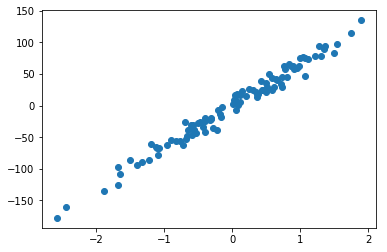

In [27]:
plt.scatter(X, y)
plt.show()